## Imports

In [1]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib
import Funciones_EDA as EDA
import sklearn.decomposition as decomposition
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

from sklearn.metrics import silhouette_score, silhouette_samples, precision_recall_fscore_support
import pingouin as pg
from factor_analyzer import FactorAnalyzer
import statsmodels.api as sm

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:.2f}'.format)

path='C:/Repo/MiM_Analytics_Tesis/Tesis/'
#path='C:/Users/E0662122/Repo/MiM_Analytics_Tesis/Tesis/'

C:\Users\fabri\AppData\Roaming\Python\Python38\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
postgreSQL = {"host": "localhost", "port": "5432", "username": "postgres", 
               "password": "trivisono", "database": "SportsAnalytics"}

uri = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(postgreSQL['username'], postgreSQL['password'], postgreSQL['host'], postgreSQL['port'], postgreSQL['database'])

engine = create_engine(uri)
conn = engine.raw_connection()
cursor = conn.cursor()

In [5]:
df_perf_index = pd.read_sql_query("SELECT * FROM fdm.dash_ft_abt_season_players_train;", conn)

rating_correction = pd.read_sql_query("SELECT player_id, \
    SUM(player_rating*player_minutes)/NULLIF(SUM(CASE WHEN player_rating=0 THEN 0 ELSE player_minutes END), 0) wavg_player_rating \
    FROM fdm.ft_api_matches_stats_players AS stats_players GROUP BY player_id \
    HAVING SUM(player_rating*player_minutes)/NULLIF(SUM(CASE WHEN player_rating=0 THEN 0 ELSE player_minutes END), 0) IS NOT NULL", conn)

In [7]:
df_perf_index.to_csv(path+'AR_players_20220210.csv', encoding='utf-8', decimal='.', sep='|')
rating_correction.to_csv(path+'AR_rating_correction_20220203.csv', encoding='utf-8', decimal='.', sep='|')

In [6]:
df_perf_index

,league_season,player_id,player_name,player_preferred_position,player_preferred_number,team_id,team_name,team_country,avg_team_position,avg_league_cov,player_minutes,wavg_player_rating,offsides,shots_total,shots_on_goal,goals_total,goals_conceded_padj,shots_on_goal_opp_padj,goals_assists,goals_saves_padj,passes_total,passes_key,passes_completed,tackles_total_padj,tackles_blocks_padj,tackles_interceptions_padj,duels_total_padj,duels_won_padj,dribbles_attemps,dribbles_success,dribbles_past_padj,fouls_drawn,fouls_committed_padj,cards_yellow,cards_red,penalty_won,penalty_committed_padj,penalty_scored,penalty_missed,penalty_saved
0,2016,0,None,M,15,453,Independiente,Argentina,0.69,0.36,2182,NaN,0,18,6,0,27.99,129.45,1,15.84,24,0,12.96,41.27,2.31,32.16,0.00,0.00,0,0,0.00,26,25.10,7,1,0,0.00,0,0,0
1,2016,1,Roman Burki,G,38,165,Borussia Dortmund,Germany,0.61,0.35,1080,6.66,0,0,0,0,20.11,52.60,0,32.01,292,0,221.22,0.00,0.00,0.00,11.30,9.30,2,2,0.00,2,0.71,2,0,0,0.00,0,0,0
2,2016,2,Marwin Hitz,G,35,170,FC Augsburg,Germany,0.11,0.35,900,6.35,0,0,0,0,17.61,44.81,0,27.98,189,0,108.15,0.00,0.00,0.00,4.08,2.39,1,0,0.00,1,1.00,3,0,0,0.00,0,0,1
3,2016,7,Abdou Diallo,D,34,91,Monaco,France,1.00,0.43,386,7.22,0,2,0,0,0.00,14.82,0,0.00,174,0,143.88,0.00,0.00,13.29,36.81,18.55,2,1,1.00,1,6.87,0,0,0,1.00,0,0,0
4,2016,8,Raphael Guerreiro,D,13,165,Borussia Dortmund,Germany,0.61,0.35,773,7.18,0,17,6,3,0.00,49.82,0,0.00,405,13,325.08,0.00,0.00,21.51,81.69,38.84,20,11,4.61,5,7.12,0,0,0,0.00,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39478,2021,344881,Juan Tovar,F,14,1130,Huila,Colombia,0.00,0.47,0,NaN,0,0,0,0,0.00,3.33,0,0.00,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0.00,0,0.00,0,0,0,0.00,0,0,0
39479,2021,344883,John Mendez,F,26,1130,Huila,Colombia,0.00,0.47,0,NaN,0,0,0,0,0.00,3.33,0,0.00,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0.00,0,0.00,0,0,0,0.00,0,0,0
39480,2021,344937,Gabriel Bran,G,32,1128,Independiente Medellin,Colombia,0.48,0.47,0,NaN,0,0,0,0,0.00,5.66,0,0.00,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0.00,0,0.00,0,0,0,0.00,0,0,0
39481,2021,344938,Juan Espitia,G,12,1139,Santa Fe,Colombia,0.67,0.47,0,NaN,0,0,0,0,0.00,1.52,0,0.00,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0.00,0,0.00,0,0,0,0.00,0,0,0


In [14]:
df = df_perf_index.copy()

In [19]:
df_scoring = df[df['team_country'].isin(['Argentina', 'Brazil', 'Mexico', 'Colombia', 'Peru', 'Chile'])].reset_index(drop=True)
df_scoring.to_csv(path+'AR_scoring_20220210.csv', encoding='utf-8', decimal='.', sep='|')

## Functions

In [2]:
def get_cronbach_alpha(df, df_factors, factors, threshold=0.5):
    list_c_alpha = []
    for factor in range(factors):
        cols_factor = df_factors[(~df_factors.index.isin(['Variance', 'Proportional Variance (%)', 'Cummulative (%)', 'Expl.Var/Tot (%)'])) & (df_factors[f'Factor {factor+1}']>=threshold)].index
        try:
            list_c_alpha.append([f'Sq Norm Factor {factor+1}', 
                                 pg.cronbach_alpha(df[cols_factor])[0], # C-Alpha
                                 pg.cronbach_alpha(df[cols_factor])[1]]) # Confidence Interval
        except:
            pass

    return pd.DataFrame(list_c_alpha, columns=['Factor', 'C-Alpha', 'Conf. Interval'])

In [3]:
def get_factors(x, factors, method='principal', rotation='varimax', thresh_c_alpha=0.5):
    fa = FactorAnalyzer(factors, method=method, rotation=rotation)
    fa.fit(x)
    # Get loadings
    loads = fa.loadings_
    # Get Variance
    var = pd.DataFrame(fa.get_factor_variance(), index=['Variance', 'Proportional Variance (%)', 'Cummulative (%)'], 
                 columns=['Factor {}'.format(fact+1) for fact in range(factors)])
    # Get Communalities
    communalities = pd.DataFrame(fa.get_communalities(), columns=['Communalities'], index=x.columns)
    # Calculate Normalized Squared Factor Loadings
    variances = fa.get_factor_variance()[0]
    sq_norm_variances = (loads**2)/variances
    variances_pct = [variances[i]/sum(variances) for i in range(len(variances))]
    # Consolidate
    df_variances_pct = pd.DataFrame(variances_pct, index=['Factor {}'.format(fact+1) for fact in range(factors)], columns=['Expl.Var/Tot (%)']).transpose()
    df_sq_factors = pd.DataFrame(sq_norm_variances, index=x.columns, columns=['Sq Norm Factor {}'.format(fact+1) for fact in range(factors)])
    df_factors = pd.DataFrame(loads, index=x.columns, columns=['Factor {}'.format(fact+1) for fact in range(factors)])
    df_weights = pd.DataFrame(np.sum(sq_norm_variances*variances_pct, axis=1), index=x.columns, columns=['PC_Weight'])
    df_factors_var = pd.concat([pd.concat([df_factors, var, df_variances_pct]), communalities, df_sq_factors, df_weights], axis=1)
    df_factors_var = df_factors_var.fillna('-')
    
    # Calculate Cronbach's coefficient alpha
    df_c_alpha = get_cronbach_alpha(x, df_factors_var, factors, threshold=thresh_c_alpha)
    
    return df_factors_var, df_c_alpha

## Preprocessing

In [8]:
df = df[(df['player_minutes']>=270) & (df['player_id']>0)].copy()

In [9]:
## Per 90 stats
# Attacking
df['offsides_p90'] = df['offsides']/df['player_minutes']*90
df['shots_p90'] = df['shots_total']/df['player_minutes']*90
df['shooting_accuracy'] = np.where(df['shots_total']==0, 0, np.where(df['shots_total']<df['shots_on_goal'], 1,
                                                                     df['shots_on_goal']/df['shots_total']))
df['goals_p90'] = df['goals_total']/df['player_minutes']*90
df['np_goals_p90'] = np.where(df['goals_total']-df['penalty_scored']<0, 0, 
                              (df['goals_total']-df['penalty_scored'])/df['player_minutes']*90)
df['goal_conversion'] = np.where(df['shots_total']==0, 0, df['goals_total']/df['shots_total'])
df['goal_conversion_np'] = np.where(df['shots_total']==0, 0, (df['goals_total']-df['penalty_scored'])/df['shots_total'])
df['assists_p90'] = df['goals_assists']/df['player_minutes']*90
df['penalty_won_p90'] = df['penalty_won']/df['player_minutes']*90
df['penalty_missed_p90'] = df['penalty_missed']/df['player_minutes']*90

# Build-up
df['passes_p90'] = df['passes_total']/df['player_minutes']*90
df['passing_accuracy'] = np.where(df['passes_total']==0, 0, df['passes_completed']/df['passes_total'])
df['key_passes_p90'] = df['passes_key']/df['player_minutes']*90
df['fouls_drawn_p90'] = df['fouls_drawn']/df['player_minutes']*90

# Defense
df['tackles_p90'] = df['tackles_total_padj']/df['player_minutes']*90
df['blocks_p90'] = df['tackles_blocks_padj']/df['player_minutes']*90
df['interceptions_p90'] = df['tackles_interceptions_padj']/df['player_minutes']*90
df['saves_p90'] = df['goals_saves_padj']/df['player_minutes']*90
df['penalty_saves_p90'] = df['penalty_saved']/df['player_minutes']*90
df['penalty_committed_p90'] = df['penalty_committed_padj']/df['player_minutes']*90
df['goals_conceded_p90'] = df['goals_conceded_padj']/df['player_minutes']*90
df['shots_on_goal_opp_p90'] = df['shots_on_goal_opp_padj']/df['player_minutes']*90
df['goals_conceded_ratio'] = df['goals_conceded_p90']/df['shots_on_goal_opp_p90']
df['fouls_committed_p90'] = df['fouls_committed_padj']/df['player_minutes']*90

# One vs one
df['duels_p90'] = df['duels_total_padj']/df['player_minutes']*90
df['duels_success_ratio'] = np.where(df['duels_total_padj']==0, 0, df['duels_won_padj']/df['duels_total_padj'])
df['dribbles_p90'] = df['dribbles_attemps']/df['player_minutes']*90
df['dribbles_success_ratio'] = np.where(df['dribbles_attemps']==0, 0, df['dribbles_success']/df['dribbles_attemps'])
df['dribbles_past_p90'] = df['dribbles_past_padj']/df['player_minutes']*90

# General
df['cards_yellow_p90'] = df['cards_yellow']/df['player_minutes']*90
df['cards_red_p90'] = df['cards_red']/df['player_minutes']*90

# Combined
df['scoring_contribution'] = df['np_goals_p90']+df['assists_p90']

In [10]:
# Fill NAs rating with ratings from the same players in other seasons
df = df.merge(rating_correction, on=['player_id'], how='left')
df['wavg_player_rating'] = np.where(df['wavg_player_rating_x'].isna(), df['wavg_player_rating_y'], df['wavg_player_rating_x'])
del df['wavg_player_rating_x'], df['wavg_player_rating_y']

# Fill NAs rating with average rating of the position in the entire dataset
df_ratings_pos = df[['player_preferred_position', 'wavg_player_rating']].groupby(['player_preferred_position']).median().rename(
    columns={'wavg_player_rating': 'wavg_position_rating'}).reset_index()
df = df.merge(df_ratings_pos, on=['player_preferred_position'], how='left')
df['wavg_player_rating'] = np.where(df['wavg_player_rating'].isna(), df['wavg_position_rating'], df['wavg_player_rating'])
del df['wavg_position_rating']

In [12]:
df.to_csv(path+'AR_season_20220131.csv', encoding='utf-8', decimal='.', sep='|')

In [10]:
df = pd.read_csv(path+'AR_season_20220131.csv', encoding='utf-8', decimal='.', sep='|')

### Variable Selection

In [5]:
player_cols = ['league_season', 'team_id', 'team_name', 'player_id', 'player_name', 'player_preferred_position', 'wavg_player_rating']

fw_cols = ['np_goals_p90', 'shots_p90', 'shooting_accuracy', 'goal_conversion_np', 'passing_accuracy', 'assists_p90', 
           'key_passes_p90', 'dribbles_p90', 'dribbles_success_ratio', #'scoring_contribution', 
           'tackles_p90', 'interceptions_p90']#, 'avg_team_position', 'avg_league_cov'] 

mf_cols = ['passes_p90', 'passing_accuracy', 'key_passes_p90', 'scoring_contribution', 'dribbles_p90', 'dribbles_success_ratio', 
           'fouls_drawn_p90', 'fouls_committed_p90', 'dribbles_past_p90', 'tackles_p90',  'interceptions_p90']#, 'avg_team_position', 'avg_league_cov']

df_cols = ['passes_p90', 'passing_accuracy', 'fouls_drawn_p90', 'fouls_committed_p90', 'dribbles_past_p90', 
           'duels_p90', 'duels_success_ratio', 'tackles_p90', 'blocks_p90', 'interceptions_p90', 'penalty_committed_p90']#, 'avg_team_position', 'avg_league_cov']

gk_cols = ['saves_p90', 'goals_conceded_p90', 'goals_conceded_ratio', 'passes_p90', 'passing_accuracy', 'fouls_drawn_p90', 'fouls_committed_p90', 
           'duels_p90', 'duels_success_ratio', 'tackles_p90', 'blocks_p90', 'interceptions_p90', 'penalty_committed_p90']#, 'avg_team_position', 'avg_league_cov']

### Unification of Optimizing Direction for all Variables

In [6]:
df['fouls_committed_p90'] = df['fouls_committed_p90']*-1
df['dribbles_past_p90'] = df['dribbles_past_p90']*-1
df['penalty_committed_p90'] = df['penalty_committed_p90']*-1
df['goals_conceded_p90'] = df['goals_conceded_p90']*-1

### Normalization

In [7]:
df_fw_0 = df[df['player_preferred_position'] == 'F'][player_cols+fw_cols].copy()
df_mf_0 = df[df['player_preferred_position'] == 'M'][player_cols+mf_cols].copy()
df_df_0 = df[df['player_preferred_position'] == 'D'][player_cols+df_cols].copy()
df_gk_0 = df[df['player_preferred_position'] == 'G'][player_cols+gk_cols].copy()

In [8]:
df_fw = pd.concat([df_fw_0[player_cols].reset_index(drop=True), 
                   pd.DataFrame(RobustScaler().fit_transform(df_fw_0[fw_cols]), columns=fw_cols)], axis=1)

df_mf = pd.concat([df_mf_0[player_cols].reset_index(drop=True), 
                   pd.DataFrame(RobustScaler().fit_transform(df_mf_0[mf_cols]), columns=mf_cols)], axis=1)

df_df = pd.concat([df_df_0[player_cols].reset_index(drop=True), 
                   pd.DataFrame(RobustScaler().fit_transform(df_df_0[df_cols]), columns=df_cols)], axis=1)

df_gk = pd.concat([df_gk_0[player_cols].reset_index(drop=True), 
                   pd.DataFrame(RobustScaler().fit_transform(df_gk_0[gk_cols]), columns=gk_cols)], axis=1)

## Factor Analysis

In [36]:
position = 'Goalkeeper'
cols_train = gk_cols
df_train = df_gk.copy()

### Train

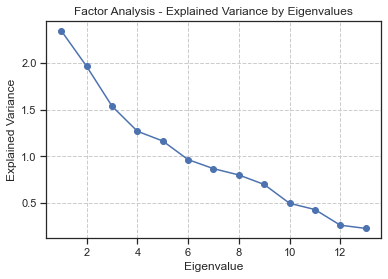

In [37]:
# Fit Factor Analyzer
x = df_train[cols_train]
fa = FactorAnalyzer()
fa.fit(x, 20)
# Get Eigenvalues and plot them
ev, v = fa.get_eigenvalues()
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(range(1,x.shape[1]+1),ev,marker='o')
plt.title('Factor Analysis - Explained Variance by Eigenvalues')
plt.xlabel('Eigenvalue')
plt.ylabel('Explained Variance')
plt.grid(linestyle='--')
plt.savefig('plots_and_tables/'+position+'_FactorAnalysis_ExplainedVariance.png')

Stopping rules criteria used: 

- Scree plot (retain all eigenvalues in the sharp descent before the first one on the line where they start to level off)
- Kaiser criterion (drop all factors with eigenvalues below 1.0)
- Variance explained (keep enough factors to account for 60% of the variation)

In [38]:
# Fit Factor Analyzer
factors=5
method='principal'
rotation='varimax'

fa = FactorAnalyzer(factors, method=method, rotation=rotation)
fa.fit(x)
loads = fa.loadings_
variances = fa.get_factor_variance()[0]
sq_norm_variances = (loads**2)/variances
variances_pct = [variances[i]/sum(variances) for i in range(len(variances))]

In [39]:
display(get_factors(x, factors=factors, method='principal', rotation='varimax')[0])
display(get_factors(x, factors=factors, method='principal', rotation='varimax')[1])

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Communalities,Sq Norm Factor 1,Sq Norm Factor 2,Sq Norm Factor 3,Sq Norm Factor 4,Sq Norm Factor 5,PC_Weight
saves_p90,-0.02,0.05,-0.01,0.00,0.96,0.93,0.00,0.00,0.00,0.00,0.79,0.11
goals_conceded_p90,-0.03,0.14,0.89,0.08,-0.23,0.87,0.00,0.01,0.52,0.00,0.04,0.11
goals_conceded_ratio,-0.04,0.33,-0.79,-0.02,-0.36,0.87,0.00,0.06,0.41,0.00,0.11,0.10
passes_p90,-0.02,-0.79,0.01,-0.05,0.19,0.66,0.00,0.33,0.00,0.00,0.03,0.08
passing_accuracy,0.07,0.84,-0.16,-0.05,0.09,0.75,0.00,0.37,0.02,0.00,0.01,0.09
fouls_drawn_p90,0.11,0.06,0.01,0.71,0.04,0.52,0.01,0.00,0.00,0.33,0.00,0.06
fouls_committed_p90,-0.81,0.12,0.16,-0.04,0.05,0.70,0.31,0.01,0.02,0.00,0.00,0.09
duels_p90,0.66,-0.08,-0.08,0.60,0.02,0.81,0.21,0.00,0.00,0.23,0.00,0.10
duels_success_ratio,-0.14,-0.03,0.10,0.79,-0.04,0.66,0.01,0.00,0.01,0.41,0.00,0.08
tackles_p90,0.61,-0.17,-0.02,0.02,0.05,0.40,0.17,0.01,0.00,0.00,0.00,0.05


,Factor,C-Alpha,Conf. Interval
0,Sq Norm Factor 1,0.39,"[0.35, 0.433]"
1,Sq Norm Factor 2,0.06,"[-0.025, 0.133]"
2,Sq Norm Factor 4,0.57,"[0.536, 0.599]"


In [40]:
df_factors = get_factors(x, factors=factors, method='principal', rotation='varimax')[0]
df_variances = df_factors.iloc[df_factors.index == 'Expl.Var/Tot (%)', 0:factors]
df_variances

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5
Expl.Var/Tot (%),0.26,0.23,0.18,0.19,0.14


### Scoring

In [41]:
def score_performance_index(df_factors, df_train, player_cols, train_cols, sensitivity=False, df_sensitivity=None):
    
    # Weights calculation
    weights_f1 = np.array(df_factors.iloc[:-(len(df_factors)-len(cols_train)), -6])
    weights_f2 = np.array(df_factors.iloc[:-(len(df_factors)-len(cols_train)), -5])
    weights_f3 = np.array(df_factors.iloc[:-(len(df_factors)-len(cols_train)), -4])
    weights_f4 = np.array(df_factors.iloc[:-(len(df_factors)-len(cols_train)), -3])
    weights_f5 = np.array(df_factors.iloc[:-(len(df_factors)-len(cols_train)), -2])
    weights = np.array(df_factors.iloc[:-(len(df_factors)-len(cols_train)), -1])
    
    # Scoring
    df_perf_idx = df_train.set_index(player_cols)[cols_train]
    df_perf_idx['Factor_1'] = np.sum(df_perf_idx[cols_train]*weights_f1, axis=1)
    df_perf_idx['Factor_2'] = np.sum(df_perf_idx[cols_train]*weights_f2, axis=1)
    df_perf_idx['Factor_3'] = np.sum(df_perf_idx[cols_train]*weights_f3, axis=1)
    df_perf_idx['Factor_4'] = np.sum(df_perf_idx[cols_train]*weights_f4, axis=1)
    df_perf_idx['Factor_5'] = np.sum(df_perf_idx[cols_train]*weights_f5, axis=1)
    df_perf_idx['Perf_Index'] = np.sum(df_perf_idx[cols_train]*weights, axis=1)
    
    # Scaling
    df_perf_idx['Factor_1_scaled'] = MinMaxScaler().fit_transform(pd.DataFrame(df_perf_idx['Factor_1']))
    df_perf_idx['Factor_2_scaled'] = MinMaxScaler().fit_transform(pd.DataFrame(df_perf_idx['Factor_2']))
    df_perf_idx['Factor_3_scaled'] = MinMaxScaler().fit_transform(pd.DataFrame(df_perf_idx['Factor_3']))
    df_perf_idx['Factor_4_scaled'] = MinMaxScaler().fit_transform(pd.DataFrame(df_perf_idx['Factor_4']))
    df_perf_idx['Factor_5_scaled'] = MinMaxScaler().fit_transform(pd.DataFrame(df_perf_idx['Factor_5']))
    
    scaler = MinMaxScaler()
    scaler = scaler.fit(pd.DataFrame(df_perf_idx['Perf_Index']))
    df_perf_idx['Perf_Index_scaled'] = scaler.transform(pd.DataFrame(df_perf_idx['Perf_Index']))
    
    if sensitivity:
        df_sensitivity['Perf_Index'] = np.sum(df_sensitivity[cols_train]*weights, axis=1)
        df_sensitivity['Perf_Index_scaled'] = scaler.transform(pd.DataFrame(df_sensitivity['Perf_Index']))
        return df_sensitivity        
    else:
        return df_perf_idx        

In [42]:
df_perf_idx = score_performance_index(df_factors, df_train, player_cols, cols_train)

### Evaluation

In [43]:
cols_analysis = ['Factor_1', 'Factor_2', 'Factor_3', 'Factor_4', 'Factor_5', 'Perf_Index', 
                 'Factor_1_scaled', 'Factor_2_scaled', 'Factor_3_scaled', 'Factor_4_scaled', 'Factor_5_scaled', 'Perf_Index_scaled']
df_idx_analysis = df_perf_idx[cols_analysis].reset_index().sort_values('Perf_Index_scaled', ascending=False)

In [44]:
df_idx_analysis['cat_player_rating'] = np.select([df_idx_analysis['wavg_player_rating']<6.5,
                                                  df_idx_analysis['wavg_player_rating']<7,
                                                  df_idx_analysis['wavg_player_rating']<7.5,
                                                  df_idx_analysis['wavg_player_rating']<8,
                                                  df_idx_analysis['wavg_player_rating']<8.5], 
                                                 ['1-6.5', '6.5-7', '7-7.5', '7.5-8', '8-8.5'], default=['8.5-10'])

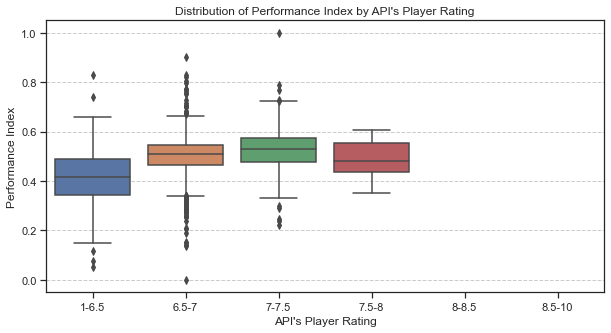

In [45]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x="cat_player_rating", y="Perf_Index_scaled", data=df_idx_analysis,
            order=['1-6.5', '6.5-7', '7-7.5', '7.5-8', '8-8.5', '8.5-10'], ax=ax)
ax.set_title("Distribution of Performance Index by API's Player Rating")
ax.set_ylabel("Performance Index")
ax.set_xlabel("API's Player Rating")
ax.yaxis.grid(linestyle='--')
plt.savefig('plots_and_tables/'+position+'_BoxPlot_PerfIndex_Rating.png')

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



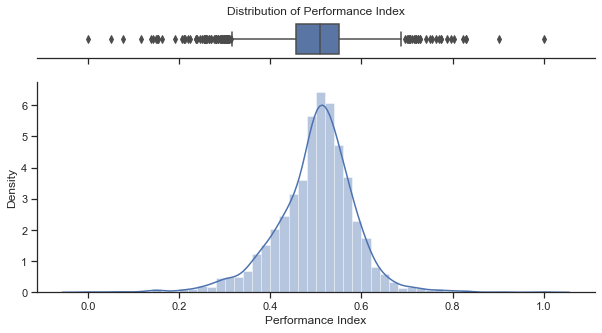

In [46]:
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(10, 5),
                                      gridspec_kw={"height_ratios": (.15, .85)})
sns.set(style="ticks")
sns.boxplot(df_idx_analysis['Perf_Index_scaled'], ax=ax_box)
sns.distplot(df_idx_analysis['Perf_Index_scaled'], ax=ax_hist)

ax_box.set(yticks=[], xlabel='')
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)
ax_box.set_title("Distribution of Performance Index")
ax_hist.set_xlabel('Performance Index')
plt.savefig('plots_and_tables/'+position+'_PerfIndex_Distribution.png')

In [47]:
df_idx_analysis[df_idx_analysis['Perf_Index_scaled']>0.85][['player_name', 'team_name', 'league_season', 'Perf_Index_scaled']]

,player_name,team_name,league_season,Perf_Index_scaled
1445,Luis Malagon,Monarcas,2019,1.00
896,Yerko Urra,Huachipato,2018,0.90


In [48]:
df_idx_analysis[df_idx_analysis['player_name']== 'Franco Armani']

,league_season,team_id,team_name,player_id,player_name,player_preferred_position,wavg_player_rating,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5,Perf_Index,Factor_1_scaled,Factor_2_scaled,Factor_3_scaled,Factor_4_scaled,Factor_5_scaled,Perf_Index_scaled,cat_player_rating
1632,2020,435,River Plate,2463,Franco Armani,G,6.51,2.77,-0.07,-1.04,0.43,1.46,0.79,0.75,0.42,0.52,0.23,0.64,0.76,6.5-7
52,2016,1137,Atletico Nacional,2463,Franco Armani,G,7.07,0.13,0.03,0.17,0.14,0.27,0.13,0.48,0.47,0.73,0.20,0.46,0.55,7-7.5
404,2017,1137,Atletico Nacional,2463,Franco Armani,G,7.04,-0.01,0.07,0.13,0.13,0.26,0.10,0.46,0.48,0.72,0.20,0.46,0.54,7-7.5
787,2018,435,River Plate,2463,Franco Armani,G,7.31,0.01,-0.23,0.18,0.12,0.36,0.06,0.47,0.36,0.73,0.20,0.48,0.53,7-7.5
2000,2021,435,River Plate,2463,Franco Armani,G,6.93,0.00,-0.28,0.10,0.09,-0.07,-0.04,0.46,0.34,0.72,0.20,0.41,0.50,6.5-7
1217,2019,435,River Plate,2463,Franco Armani,G,6.91,-0.54,-0.12,0.13,0.03,0.27,-0.10,0.41,0.41,0.72,0.19,0.46,0.48,6.5-7


In [49]:
import plotly.graph_objects as go

player_name = 'Franco Armani'
season = 2020

# Player
factors_cols = ['player_name',  'Factor_1_scaled', 'Factor_2_scaled', 'Factor_3_scaled', 'Factor_4_scaled', 'Factor_5_scaled']
player_mask = (df_idx_analysis['player_name']==player_name) & (df_idx_analysis['league_season']==season)
df_player_radar = round(df_idx_analysis[player_mask][factors_cols].set_index('player_name')*100)
player_values = df_player_radar.values.flatten().tolist()
player_values += player_values[:1]

# Avg Player
factor1_avg = df_idx_analysis['Factor_1_scaled'].mean()
factor2_avg = df_idx_analysis['Factor_2_scaled'].mean()
factor3_avg = df_idx_analysis['Factor_3_scaled'].mean()
factor4_avg = df_idx_analysis['Factor_4_scaled'].mean()
factor5_avg = df_idx_analysis['Factor_5_scaled'].mean()
df_avg_player = round(pd.DataFrame({'AvgPlayer': 
                                    [factor1_avg, factor2_avg, factor3_avg, factor4_avg, factor5_avg]}).transpose()*100)
avg_player_values = df_avg_player.values.flatten().tolist()
avg_player_values += avg_player_values[:1]

if position == 'Forward':
    categories = ['Efectiveness','Assistance','Attack','Dribbling', 'Defense']
if position == 'Midfielder':
    categories = ['Attack', 'Defense','Passing','Aggressiveness', 'Dribbling']
if position == 'Defender':
    categories = ['Aggressiveness','Passing','Duels','Penalties', 'Interceptions']
if position == 'Goalkeeper':
    categories = ['Defense','Passing','Clean Sheets','Duels', 'Saves']
    
categories = [*categories, categories[0]]

fig = go.Figure(
    data=[
        go.Scatterpolar(r=avg_player_values, theta=categories, fill='toself', name='Avg Goalkeeper'),
        go.Scatterpolar(r=player_values, theta=categories, fill='toself', name=player_name)
    ],
    layout=go.Layout(
        title=go.layout.Title(text='Player comparison'),
        polar={'radialaxis': {'visible': True, 'range': [0, 100]}},
        showlegend=True
    )
)

fig
fig.write_image('plots_and_tables/'+position+'_RadarChart_Armani2020.png')

### Sensitivity Analysis

In [26]:
position = 'Defender'
cols_train = df_cols
df_train = df_df.copy()

In [27]:
factors=5
df_factors = get_factors(df_train[cols_train], factors=factors, method='principal', rotation='varimax')[0]

In [28]:
min_list = []
half_step_min = []
mean_list = []
half_step_max = []
max_list = []

for col in cols_train:
    min_list.append(df_train[col].min()) 
    half_step_min.append((df_train[col].mean()+df_train[col].min())/2) 
    mean_list.append(df_train[col].mean())
    half_step_max.append((df_train[col].max()+df_train[col].mean())/2) 
    max_list.append(df_train[col].max()) 

In [29]:
df_sens = pd.DataFrame([min_list, half_step_min, mean_list, half_step_max, max_list], 
             index=['Min', 'Half_Min', 'Mean', 'Half_Max', 'Max'], columns=cols_train)

In [30]:
dict_all = {}
dict_step = {}

for col in df_sens.columns:
    for step in ['Min', 'Half_Min', 'Mean', 'Half_Max', 'Max']:
        list_vars = list(cols_train)
        list_vars.remove(col)
        df_iter = pd.DataFrame(pd.concat([pd.Series(df_sens.loc[step, col], name=col), df_sens.loc['Mean', list_vars]])).transpose()
        df_iter.columns = df_sens.columns
        df_scored = score_performance_index(df_factors, df_train, player_cols, cols_train, True, df_iter)
        dict_step[step] = df_scored.loc[0,'Perf_Index_scaled']
        dict_all[col] = dict(dict_step)

In [31]:
df_scored_steps = pd.DataFrame.from_dict(dict_all)

In [32]:
for col in df_scored_steps.columns:
    df_scored_steps[col] = (df_scored_steps[col]/df_scored_steps.loc['Mean', col]-1)*100

In [33]:
df_plot = df_scored_steps.transpose()

In [34]:
df_plot['Min'] = df_plot['Min']-df_plot['Half_Min']
df_plot['Max'] = df_plot['Max']-df_plot['Half_Max']

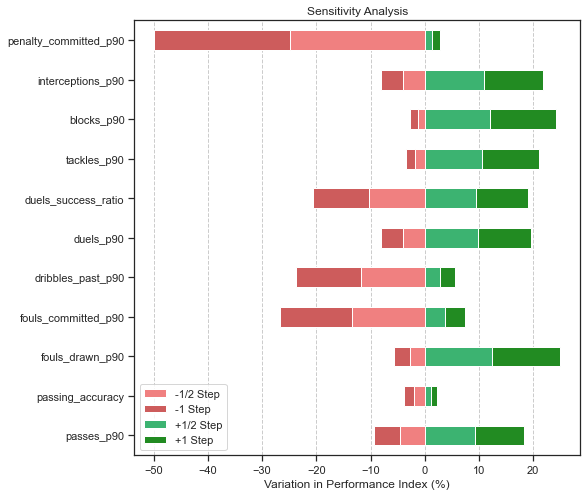

In [35]:
plot_cols = ['Half_Min', 'Min', 'Half_Max', 'Max']

fig, ax = plt.subplots(figsize=(8, 8))

df_plot[plot_cols].plot(kind='barh', stacked=True, ax=ax, color=['lightcoral', 'indianred', 'mediumseagreen', 'forestgreen'])
ax.set_xlabel('Variation in Performance Index (%)')
ax.legend(['-1/2 Step', '-1 Step', '+1/2 Step', '+1 Step'])
ax.xaxis.grid(linestyle='--')
ax.set_title('Sensitivity Analysis')

fig.savefig('plots_and_tables/'+position+'_SensitivityAnalysis.png', bbox_inches='tight', pad_inches=1)

In [108]:
def sensitivity_analysis(df, dict_perf_index, path):

    dict_sensitivity_plots = {}

    for position in ['F', 'M', 'D', 'G']:

        df_index = df[df['player_preferred_position'] == position].reset_index(drop=True)

        # Extract steps values
        min_list = []
        half_step_min = []
        mean_list = []
        half_step_max = []
        max_list = []

        for col in dict_perf_index['cols'][position]:
            min_list.append(df_index[col].min())
            half_step_min.append((df_index[col].mean()+df_index[col].min())/2)
            mean_list.append(df_index[col].mean())
            half_step_max.append((df_index[col].max()+df_index[col].mean())/2)
            max_list.append(df_index[col].max())

        df_sensitivity = pd.DataFrame([min_list, half_step_min, mean_list, half_step_max, max_list],
                                      index=['Min', 'Half_Min', 'Mean', 'Half_Max', 'Max'],
                                      columns=dict_perf_index['cols'][position])

        # Calculate index variations
        dict_all = {}
        dict_step = {}

        for col in df_sensitivity.columns:
            for step in ['Min', 'Half_Min', 'Mean', 'Half_Max', 'Max']:
                list_vars = list(dict_perf_index['cols'][position])
                list_vars.remove(col)
                df_iter = pd.DataFrame(pd.concat([pd.Series(df_sensitivity.loc[step, col], name=col),
                                                  df_sensitivity.loc['Mean', list_vars]])).transpose()
                df_iter.columns = df_sensitivity.columns
                df_iter['Perf_Index'] = np.sum(df_iter[dict_perf_index['cols'][position]]**dict_perf_index['index_weights'][position]['Weights'], axis=1)
                df_iter['Perf_Index_scaled'] = dict_perf_index['index_weights']['index_scaler'].transform(pd.DataFrame(df_iter['Perf_Index']))
                dict_step[step] = df_iter.loc[0, 'Perf_Index_scaled']
                dict_all[col] = dict(dict_step)

        df_scored_steps = pd.DataFrame.from_dict(dict_all)

        # Calculate percentual variation
        for col in df_scored_steps.columns:
            df_scored_steps[col] = (df_scored_steps[col]/df_scored_steps.loc['Mean', col]-1)*100

        # Plot variations
        df_plot = df_scored_steps.transpose()
        df_plot['Min'] = df_plot['Min']-df_plot['Half_Min']
        df_plot['Max'] = df_plot['Max']-df_plot['Half_Max']
        plot_cols = ['Half_Min', 'Min', 'Half_Max', 'Max']

        fig, ax = plt.subplots(figsize=(8, 8))
        df_plot[plot_cols].plot(kind='barh', stacked=True, ax=ax, color=['lightcoral', 'indianred', 'mediumseagreen', 'forestgreen'])
        ax.set_xlabel('Variation in Performance Index (%)')
        ax.legend(['-1/2 Step', '-1 Step', '+1/2 Step', '+1 Step'])
        ax.xaxis.grid(linestyle='--')
        fig.savefig(path+'SensitivityAnalysis_' + position + '.png', bbox_inches='tight', pad_inches=1)